In [1]:
import torch, torchvision
import os
import random
import logging #Se renseigner, par encore utilisé
import dataset
import metrics
import time

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import loss_fn_v2 as loss_fn
from unet import UNET

In [2]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold

/notebooks/vc
Training set length: 82
Validation set length: 21
Testing set length: 20
Focal
Validation loss before training: 0.18675410995880762
Epoch: 0
Training: 0.056742713476220764
Validation: 0.06649741157889366.
Epoch: 10
Training: 0.0034780882276772033
Validation: 0.003388076943034927.
Epoch: 20
Training: 0.0019977480405941606
Validation: 0.002203920118821164.
Epoch: 30
Training: 0.0012662745291544568
Validation: 0.001800258372289439.
Epoch: 40
Training: 0.0008490598771632427
Validation: 0.001694461718822519.
--------------------
Term: vc
Fold: 0
Ellapsed time: 12.0 minutes 35.89350152015686 secondes
Last val: 0.001623734540771693
Best val: 0.0014854270169356216
--------------------


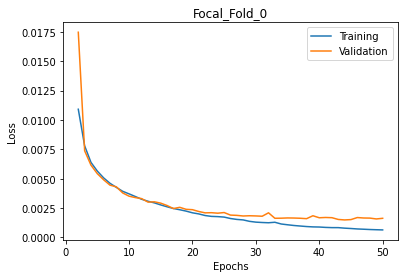

Training set length: 82
Validation set length: 21
Testing set length: 20
Focal
Validation loss before training: 0.11313653240601222
Epoch: 0
Training: 0.03441638814374095
Validation: 0.040845999494194984.
Epoch: 10
Training: 0.0019762723462744838
Validation: 0.0019958881312049925.
Epoch: 20
Training: 0.0011702295714279725
Validation: 0.0014643484028056264.
Epoch: 30
Training: 0.0007781541124651474
Validation: 0.0015765804564580321.
Epoch: 40
Training: 0.0005295146921915668
Validation: 0.0017480883398093283.
--------------------
Term: vc
Fold: 1
Ellapsed time: 12.0 minutes 20.95214533805847 secondes
Last val: 0.0015266360521006088
Best val: 0.001336775041030099
--------------------


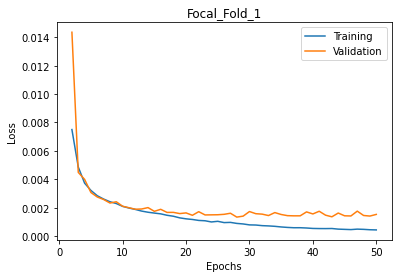

Training set length: 82
Validation set length: 21
Testing set length: 20
Focal
Validation loss before training: 0.14957943310340246
Epoch: 0
Training: 0.042822672719401975
Validation: 0.050187608848015465.
Epoch: 10
Training: 0.0025791285470837637
Validation: 0.0026205151807516813.
Epoch: 20
Training: 0.0015353942677999537
Validation: 0.0019772129987056055.
Epoch: 30
Training: 0.0009247540091607897
Validation: 0.0018020685335310798.
Epoch: 40
Training: 0.0006443973120656752
Validation: 0.001877980287342022.
--------------------
Term: vc
Fold: 2
Ellapsed time: 12.0 minutes 13.018567085266113 secondes
Last val: 0.002127878076862544
Best val: 0.0016886465794717271
--------------------
Training set length: 83
Validation set length: 20
Testing set length: 20
Focal
Validation loss before training: 0.11388944089412689
Epoch: 0
Training: 0.038494348304257506
Validation: 0.0506077878177166.
Epoch: 10
Training: 0.0029384682864128124
Validation: 0.003003273019567132.
Epoch: 20
Training: 0.0016499

In [3]:
TERMS = ["vc"]

for TERM in TERMS:
    start_term = time.time()

    DATASET = "/notebooks/images"
    MASKS = "/notebooks/" + TERM
    
    print(MASKS)

    SIZE = (384, 512)

    DEVICE_NAME = "cpu"
    if torch.cuda.is_available():
        DEVICE_NAME = 'cuda:0'
    DEVICE = torch.device(DEVICE_NAME)

    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])

    model = UNET(3, 2)
    overall_best_model = UNET(3, 2)
    overall_best_model = model
    model.to(DEVICE)

    best_fold = 0
    overall_best = 10
    best_fold_epoch = 0
    fold_best_vals = []

    image_folder = DATASET
    mask_folder = MASKS


    for fold in range(cst.FOLDS):
        start_fold = time.time()
        # Datasets and loaders
        training_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                      mask_folder,
                                                      actual_fold=fold,
                                                      dataset="train",
                                                      folds=5)
        validation_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                        mask_folder,
                                                        actual_fold=fold,
                                                        dataset="validate",
                                                        folds=5)
        testing_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="test",
                                                     folds=5)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)

        # (Channels x Classes)
        model = UNET(3, 2)
        best_model = UNET(3, 2)
        best_model = model
        model.to(DEVICE)

        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Tversky":
            print("Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"
        if cst.LOSS == "Focal":
            print("Focal")
            criterion = loss_fn.FocalLoss(alpha=0.8, gamma= 2, reduction="mean")
            criterion_string = "Focal"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)

        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)

        model.eval()
        with torch.no_grad():
            val_loss = []
            for images, masks, names in validation_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                masks = torch.squeeze(masks, 1)

                if cst.LOSS == "CE":
                    vloss = criterion(outputs, masks.to(DEVICE))
                else:
                    #vloss = criterion(outputs, F.one_hot(masks.to(DEVICE), 2).permute(0, 3, 1, 2).float())
                    vloss = criterion(outputs, masks.to(DEVICE))

                loss = vloss.detach().item()
                val_loss.append(loss)

            loss = np.mean(val_loss)
            print("Validation loss before training: {}".format(loss))

        best_val = loss
        best_epoch = 0

        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)

        epochs_train_losses = []
        epochs_val_losses = []
        for i in range(cst.EPOCHS):
            #print("Starting epoch {}".format(i+1), end=". ")

            model.train()
            train_loss = []
            for images, masks, names in training_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                #print(masks.shape)
                masks = torch.squeeze(masks, 1)

                if cst.LOSS == "CE":
                    tloss = criterion(outputs, masks.to(DEVICE))
                else:
                    tloss = criterion(outputs, masks.to(DEVICE))
                    #tloss = criterion(outputs, F.one_hot(masks.to(DEVICE), 2).permute(0, 3, 1, 2).float())

                loss = tloss.detach().item()
                train_loss.append(loss)

                optimiser.zero_grad()
                tloss.backward()
                optimiser.step()

            loss = np.mean(train_loss)
            epochs_train_losses.append(loss)
            #print("Trained: {}".format(loss), end=". ")

            model.eval()
            with torch.no_grad():
                val_loss = []
                for images, masks, names in validation_loader:
                    images = transform(images)
                    outputs = model(images.to(DEVICE))
                    outputs = untransform(outputs)

                    masks = masks.type(torch.LongTensor)
                    masks = torch.squeeze(masks, 1)

                    if cst.LOSS == "CE":
                        vloss = criterion(outputs, masks.to(DEVICE))
                    else:
                        #vloss = criterion(outputs, F.one_hot(masks.to(DEVICE), 2).permute(0, 3, 1, 2).float())
                        vloss = criterion(outputs, masks.to(DEVICE))

                    loss = vloss.detach().item()
                    val_loss.append(loss)

                loss = np.mean(val_loss)
                epochs_val_losses.append(loss)
                if i%10 == 0:
                    print("Epoch: " + str(i))
                    print("Training: {}".format(np.mean(train_loss)))
                    print("Validation: {}.".format(loss))
                #print("Validation: {}.".format(loss))

                if loss < best_val:
                    best_val = loss
                    best_model = model
                    best_epoch = i+1

        #print("Training: {}".format(epochs_train_losses))
        #print("Validating: {}".format(epochs_val_losses))
        #print("Best score: {}".format(best_val))

        #model_filepath = os.path.join(cst.MODEL, model_name)
        #best_filepath = os.path.join(cst.MODEL, best_name)
        #torch.save(model.state_dict(), model_filepath)
        #torch.save(best_model.state_dict(), best_filepath)

        fold_best_vals.append(best_val)

        if best_val < overall_best:
            overall_best = best_val
            overall_best_model = best_model
            best_fold_epoch = best_epoch
            best_fold = fold
            
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60

        print("--------------------")
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Ellapsed time: " + str(minutes) + " minutes " + str(secondes) + " secondes")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print("--------------------")
        
        


        if fold == best_fold:
            index = [i+1 for i in range(cst.EPOCHS)]
            plt.plot(index[1:], epochs_train_losses[1:], label="Training")
            plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
            plt.title(str(cst.LOSS) + "_Fold_" + str(fold)) 
            plt.ylabel("Loss")
            plt.xlabel("Epochs")
            plt.legend()
            plt.show()
            #plot_name = name + ".png"
            #plt.savefig(plot_name)
        
    # Indent back


    name = TERM + "_Fold" + str(best_fold) +  "_EPOCH" + str(best_fold_epoch) + "_Val" + str(best_val)
    name = name + criterion_string + "_" + optimiser_string + "_" + params_string
    model_name = name + ".pth"
    best_filepath = os.path.join(cst.MODEL, model_name)
    #torch.save(overall_best_model.state_dict(), best_filepath)

    curr = time.time()
    curr = curr - start_term
    secondes = curr % 60
    minutes = (curr-secondes)/60

    print("-------------------------")
    print("-----------END-----------")
    print("-------------------------")
    print("Term: " + TERM)
    print("Ellapsed time: " + str(minutes) + " minutes " + str(secondes) + " secondes")
    print("Best fold: {}".format(best_fold+1))
    print("Best validation loss: {}".format(overall_best))
    print("Best epoch: {}".format(best_fold_epoch))
    print("Mean val of folds: {}".format(np.mean(fold_best_vals)))
    print("Best vals for each fold:")
    a = 0
    for item in fold_best_vals:
        print("Fold :{}".format(a+1), end=" - ")
        print("Val: {}".format(item))
        a=a+1


    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []

    eval_model = UNET(3, 2)
    eval_model = overall_best_model

    eval_model.eval()
    for image, mask, name in testing_loader:
        image_name = name[0]
        prediction = predict_img(eval_model, transform(image), DEVICE, untransform, out_threshold=cst.THRESHOLD)
        pred = torch.from_numpy(prediction)

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))

    confidence = 0.9
    print("Name of the run: {}".format(TERM + "_" + "Fold_" + str(best_fold)))
    print("Precision: {}".format(np.mean(precisions)))
    print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(precisions), np.max(precisions))
    print()

    print("Recall: {}".format(np.mean(recalls)))
    print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(recalls), np.max(recalls))
    print()

    print("F1/Dice score: {}".format(np.mean(F1s)))
    print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(F1s), np.max(F1s))
    print()

    print("IoU: {}".format(np.mean(IOUs)))
    print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(IOUs), np.max(IOUs))
    print()